# Web Scrape Gelest

Let's import the libraries we'll need. Also, hacking the [government pdfs](https://govhack-toolkit.readthedocs.io/technical/scraping/)

In [3]:
# import libraries
import PyPDF2
from urllib.request import urlopen
import requests
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import itertools
from bs4 import BeautifulSoup
from rdkit import Chem
from rdkit.Chem import Draw

In [2]:
#helper methods
def getFlashPoint(pdfUrl):
    flashp = -1
    response = urlopen(pdfUrl)
    file = open("document.pdf", 'wb')
    file.write(response.read())
    file.close()
    pdf_file = open('document.pdf', 'rb')
        
    read_pdf = PyPDF2.PdfFileReader(pdf_file)
    
    #number_of_pages = read_pdf.getNumPages()
    for p in range(read_pdf.getNumPages()):
        page = read_pdf.getPage(p)
        text = page.extractText()
        
        text = text.replace('\n', ' ').replace('\r', '')
        fp = re.search('Flash point(.+?)C', text)
        #print(fp)
        if fp != None:
            fp = re.search('Flash point(.+?)C', text).group(0)
            flashPoint = re.findall('\d+', fp)
            #print(int(flashPoint[0]))
            flashp = int(flashPoint[0])
            break
    
    pdf_file.close()
    
    print(flashp)    
    return flashp

def removeJunk(compound):
    compound = compound.split(',')
    return compound[0]

I think we should get the box for each [product](https://www.gelest.com/product-lines/silicones/)

In [18]:
num = 1
frame = pd.DataFrame(columns=("productCode", "casNum", "compound", "smiles", "flashPoint", "img", "sds")) #frame for scraped data

while num <= 9:
    print("-------------------Page"+str(num)+"------------------------------------------")
    url = "https://www.gelest.com/product-lines/silicones/?pl_page="+str(num)+"&perpage=50"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    products = soup.find("div", {"class": re.compile("^(first border-box col-xs-24)")})
    contents = soup.find_all("div", {"class": "wc-product-meta"})
    imgs = soup.find_all("img", {"class": "img-responsive center-block wp-post-image"})
    
    for img, data in zip(imgs, contents):
        
        productCode = data.find("span", {"class" : "code"}).text
        sds = soup.find("a", {"href": "https://s3.amazonaws.com/gelest/sds/"+productCode+"_GHS+US_English+US.pdf"})
        casNo = data.find("span", {"class" : "cas-number"})
    
        if casNo == None:
            casNo = ''
        else:
            casNo = casNo.text
        
        compound = data.find("p", {"class" : "title"}).text.strip('\n\t')
        compound = removeJunk(compound)
        smilesUrl = "https://opsin.ch.cam.ac.uk/opsin/"+compound+".smi"
        #print(smilesUrl)
        requestSmiles = requests.get(smilesUrl)
    
        if requestSmiles.status_code == 400 or requestSmiles.status_code == 404:
            print("no smiles")
        else:
            try:
                if sds != None: #if sds['href'] != None:
                    #print(sds['href'])
                    if sds == None:
                        flashPoint = -1
                    else:
                        flashPoint = getFlashPoint(sds['href'])
                    frame = frame.append({'productCode' : productCode,
                             'casNum' : casNo,
                             'compound' : compound,
                              'smiles' : requestSmiles.text,
                              'flashPoint' : flashPoint,
                             'img' : img['src'],
                             'sds' : sds['href']}, ignore_index=True)
            except:
                print('could not scrap pdf')
                #print(compound, requestSmiles.text, flashPoint)
                #print(sds["href"])

    num+= 1

-------------------Page1------------------------------------------
no smiles
no smiles
-1
110
110
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
258
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
-------------------Page2------------------------------------------
no smiles
no smiles
65
no smiles
76
80
110
170
170
256
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smiles
no smi

In [19]:
frame = frame[frame.flashPoint != -1]
print(frame.shape[0])
frame.to_csv('silicones.csv', encoding='utf-8',index=False)
#sdsUrl = "https://s3.amazonaws.com/gelest/sds/SIA0482.0_GHS+US_English+US.pdf"
#fp = getFlashPoint(sdsUrl)
#print(fp)

52


In [3]:
intermediates = pd.read_csv('SpecialtyPolyethersAndOlefins.csv')
tinCompounds = pd.read_csv('tinCompounds.csv')
silanesAndSiliconCompounds = pd.read_csv('silanesandsilicon.csv')
germaniumCompounds = pd.read_csv('germaniumCompounds.csv')
silicones = pd.read_csv('silicones.csv')

compounds = silanesAndSiliconCompounds.append([intermediates,
                                               tinCompounds,
                                              germaniumCompounds,
                                              silicones])

In [4]:
print(compounds.shape[0])
compounds.head(5)
compounds.to_csv('fpData.csv')

408


# Using Opsin web services to request the smiles from IUPAC name

In [2]:
url = "https://opsin.ch.cam.ac.uk/opsin/ACETOXYETHYLTRIETHOXYSILANE.smi"
r = requests.get(url)
r.text

'C(C)(=O)OCC[Si](OCC)(OCC)OCC'

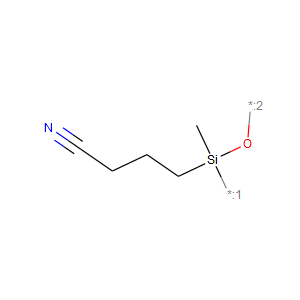

In [8]:
m = Chem.MolFromSmiles(r.text)
Draw.MolToImage(m)

m1 = Chem.MolFromSmiles('C(#N)CCC[Si](O[*:2])(C)[*:1]')
Draw.MolToImage(m1)